In [1]:
from internal import camera_utils
from internal import configs
from internal import datasets
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def line(ax, p, q, color="r"):
  """Plots a 3d line between points p and q."""
  x = [p[0], q[0]]
  y = [p[1], q[1]]
  z = [p[2], q[2]]
  ax.plot(x, y, zs=z, color=color)

def plot_pose(ax, c2w, scale):
  """Plots a pose."""
  origin = c2w[:3,3]
  x = c2w[:3, 0]
  y = c2w[:3, 1]
  z = c2w[:3, 2]

  line(ax, origin, origin + x*scale, "r")
  line(ax, origin, origin + y*scale, "g")
  line(ax, origin, origin + z*scale, "b")

def plot_poses(camtoworlds, scale=1):
  fig = plt.figure(figsize=plt.figaspect(0.5))
  ax = fig.add_subplot(1, 1, 1, projection='3d')
    
  x = camtoworlds[:, 0, 3]
  y = camtoworlds[:, 1, 3]
  z = camtoworlds[:, 2, 3]
  ax.scatter3D(x, y, z, c=np.linspace(0, 1, x.shape[0]), cmap='viridis', marker='o', s=50, alpha=0.7)
    
  for c2w in camtoworlds:
    plot_pose(ax, c2w, scale)
    
  ax.set_xlabel("X")
  ax.set_ylabel("Y")
  ax.set_zlabel("Z")
#   ax.set_xlim([-1.1, 1.1])
#   ax.set_ylim([-1.1, 1.1])
#   ax.set_zlim([-1.1, 1.1])
    
def world_from_pix_and_z(p2c, c2w, pixel_grid, depth, conf):
  # Homogeneous coords: (u, v, 1, 1/z)
  # Shape: [4, H, W]
  pix_h = np.stack([pixel_grid[0], pixel_grid[1], np.ones_like(depth), 1/depth])
  # Shape [4, H*W]
  pix_h = np.reshape(pix_h, (pix_h.shape[0], np.prod(pix_h.shape[1:])))
  depth = np.reshape(depth, (np.prod(depth.shape)))
  conf = np.reshape(conf, (np.prod(conf.shape)))

  # Convert c2w from OpenGL to OpenCV
  c2w = c2w @ np.diag([1, -1, -1, 1])
  
  points = c2w @ p2c @ pix_h * depth


  return points[:, conf * 255 > 1.5]

def get_pixel_grid(width, height):
  return np.array(np.meshgrid(np.arange(width), np.arange(height), indexing='xy'))

def save_pointcloud(points, filename):
    # Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
    pcd = o3d.geometry.PointCloud()
    points_formatted = points.T[:, :3]
    pcd.points = o3d.utility.Vector3dVector(points_formatted)
    o3d.io.write_point_cloud(filename, pcd)

In [3]:
config = configs.Config()
config.dataset_loader = 'nextcam'
config.near = 0.
config.far = 1.
config.factor = 8
config.data_dir = "/home/jebe/multinerf-lenses/data/multi2.npz"
config.llff_use_all_images_for_training = True #False
dataset1 = datasets.load_dataset('train', config.data_dir, config)
#dataset1 = datasets.load_dataset('test', config.data_dir, config)
dataset1._load_renderings(config)
print(f"Loaded {dataset1.images.shape[0]} images.")

Loaded 30 images.


In [ ]:
pixel_grid = get_pixel_grid(dataset1.width, dataset1.height)
scale = np.linalg.norm(dataset1.debug_transform[0, :3])
#scale = 1
print("scale: ", scale)

for i in [0, 8]:
  # Extend matrices to 4x4
  p2c = np.eye(4)
  p2c[:3, :3] = dataset1.pixtocams[i]
  c2w = np.eye(4)
  c2w[:3, :4] = dataset1.camtoworlds[i, :3, :4]

  depth = dataset1.depths[i]
  depth_scaled = depth * scale

  points = world_from_pix_and_z(p2c, c2w, pixel_grid, depth_scaled, dataset1.confidences[i])
  save_pointcloud(points, f"test_{i}.ply")

<IPython.core.display.Javascript object>


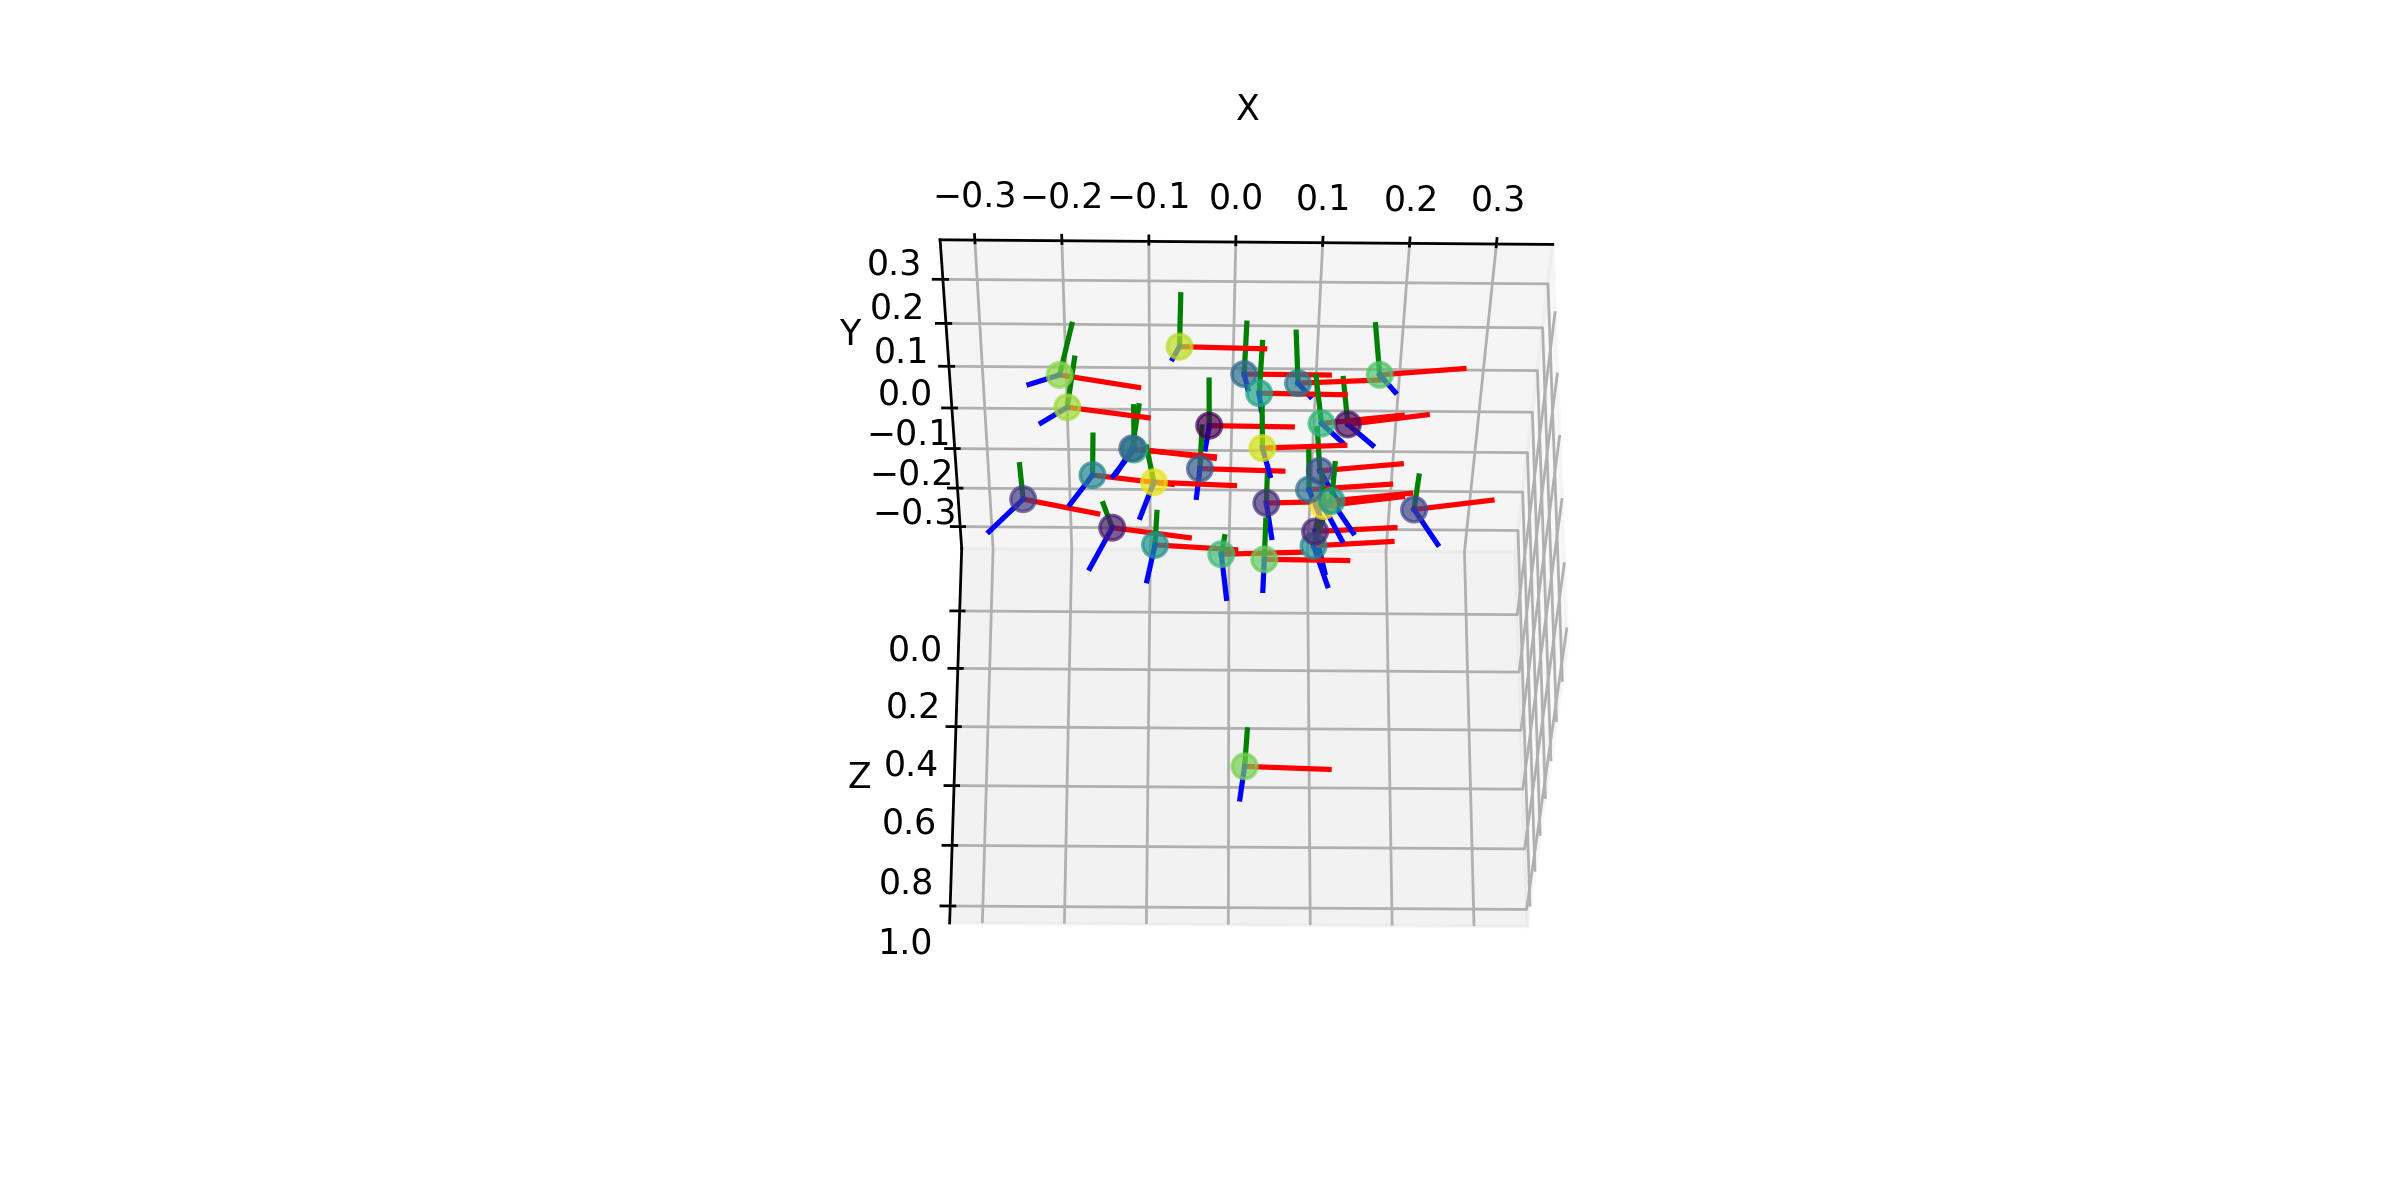

In [5]:
%matplotlib notebook
plot_poses(dataset1.camtoworlds, 0.1)

In [6]:
#DEBUG
config.render_path = True
config.render_path_frames = 30
dataset1_render = datasets.load_dataset('train', config.data_dir, config)
dataset1_render._load_renderings(config)

<IPython.core.display.Javascript object>


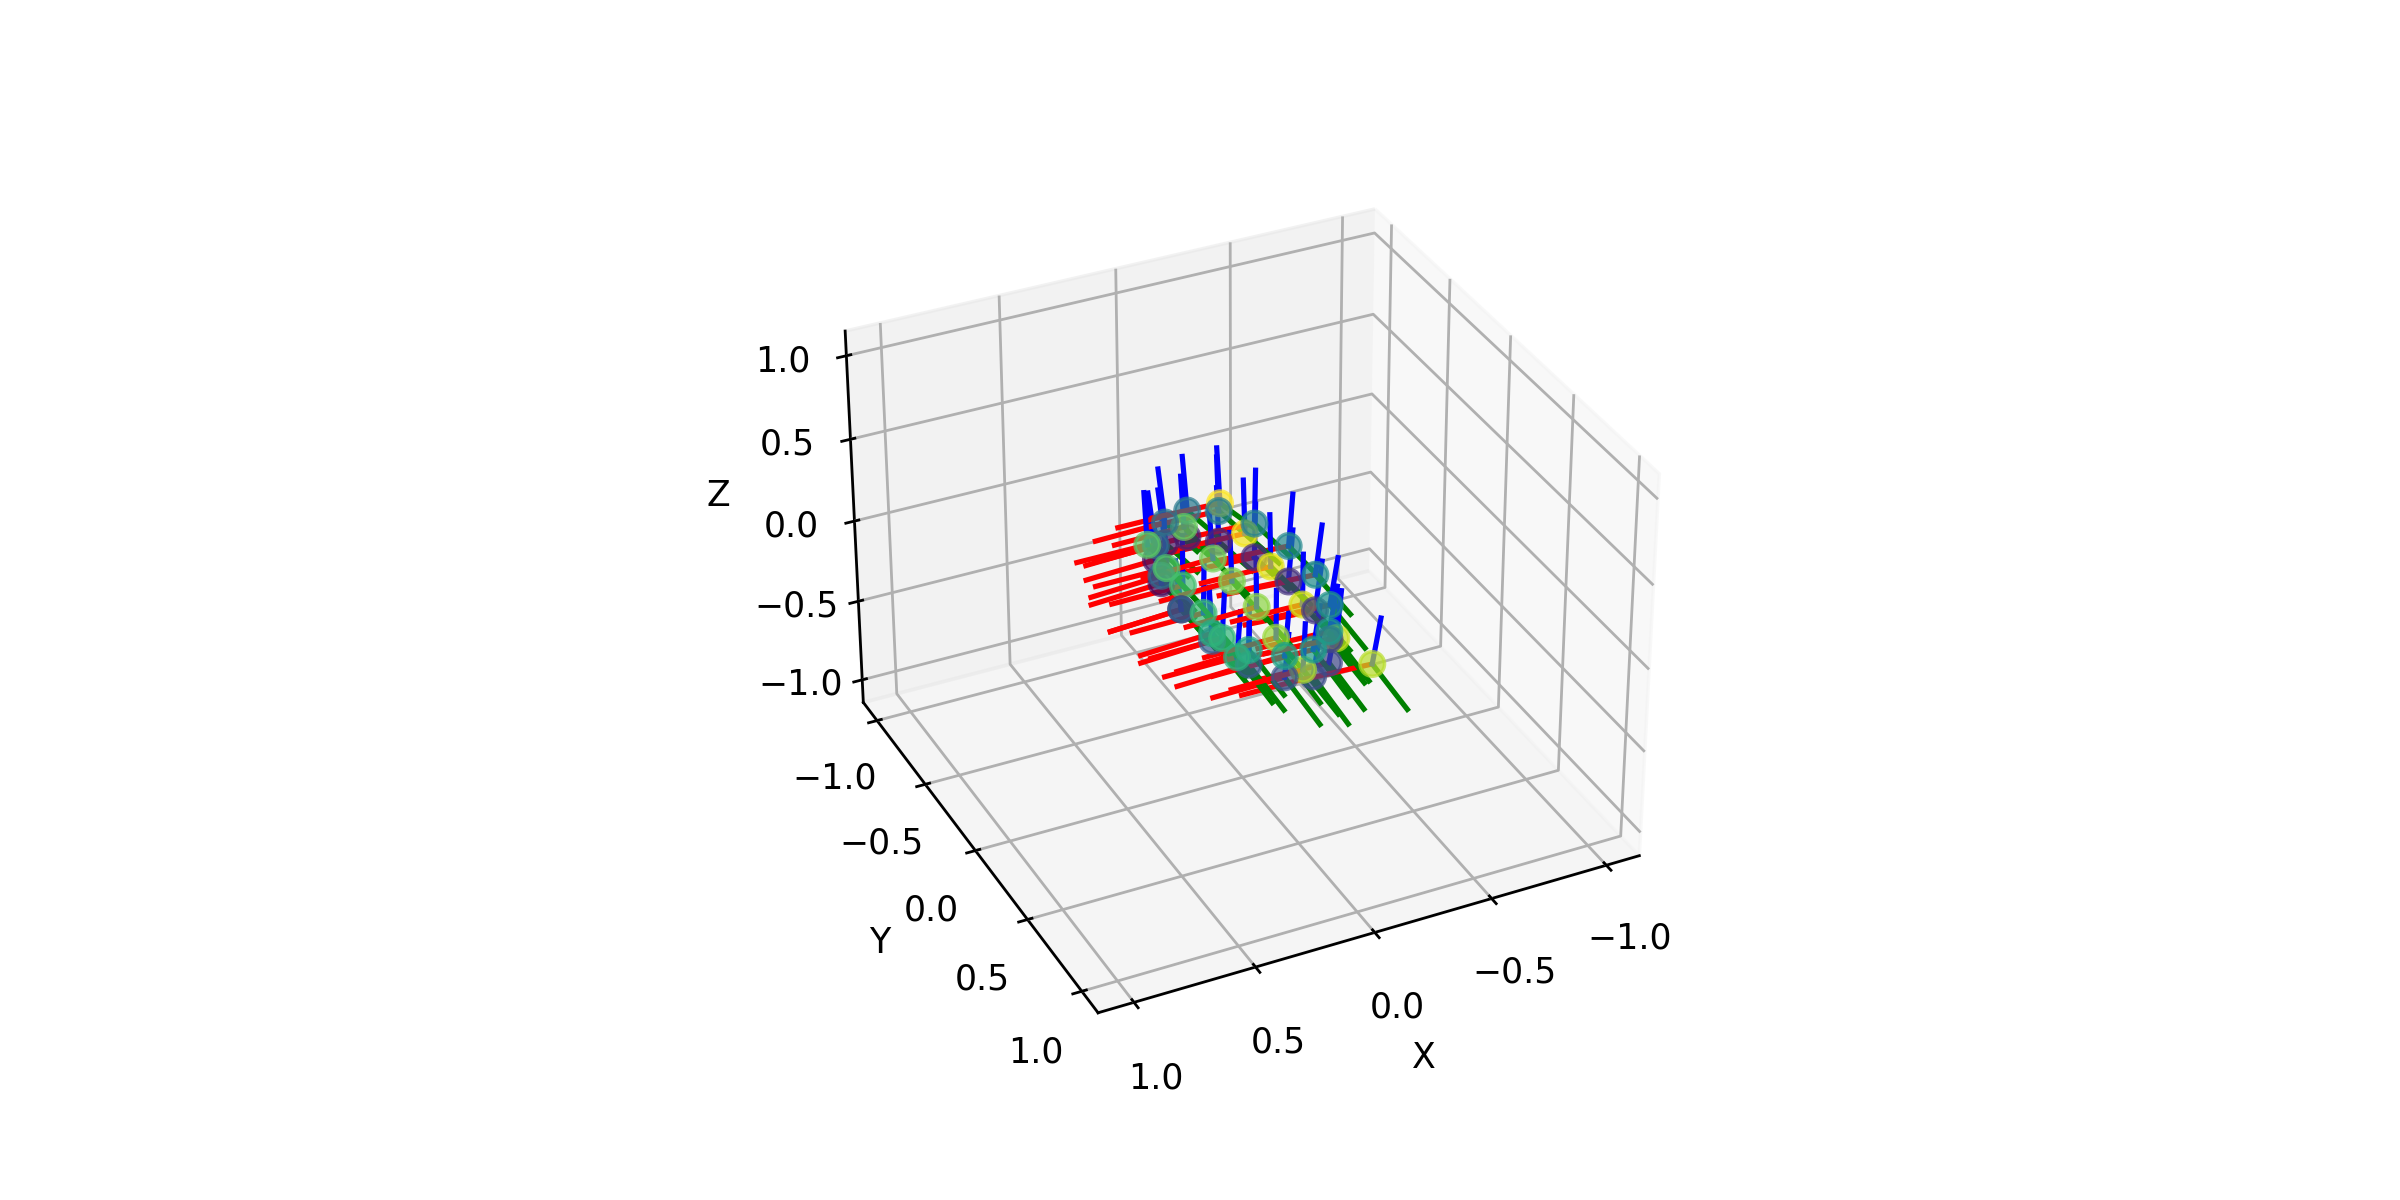

In [10]:
%matplotlib notebook
plot_poses(np.concatenate([dataset1_render.camtoworlds, dataset1.camtoworlds], axis=0), 0.3)

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(16, 16))
n_images = dataset1.images.shape[0]
for i, img in enumerate(dataset1.images):
    plt.subplot(int(np.ceil(n_images / 4)), 4, i+1)
    plt.imshow(img)

In [ ]:
print(dataset1.debug_transform)
for i in range(3):
    print(np.linalg.norm(dataset1.debug_transform[i, :3]))
    print(np.linalg.norm(dataset1.debug_transform[:3, i]))
#print(dataset1.camtoworlds[0])
#print(np.linalg.inv(dataset1.pixtocams[0]))

## LLFF Dataset comparison

In [3]:
config = configs.Config()
config.dataset_loader = 'llff'
config.near = 0.
config.far = 1.
config.factor = 8
config.forward_facing = True
config.llff_use_all_images_for_training = True
config.render_path = True
config.render_dolly_zoom = True
dataset2 = datasets.load_dataset('test', "/home/jebe/multinerf-lenses/data/fern", config)
dataset2._load_renderings(config)

In [ ]:
# Same dataset, but this time with bounds. 
dataset3 = datasets.load_dataset('train', "/home/jebe/multinerf-lenses/data/fern_copy", config)
dataset3._load_renderings(config)

In [ ]:
# Same dataset, but this time with bounds. 
dataset4 = datasets.load_dataset('train', "/home/jebe/multinerf-lenses/data/fern_copy_bounds", config)
dataset4._load_renderings(config)

<IPython.core.display.Javascript object>


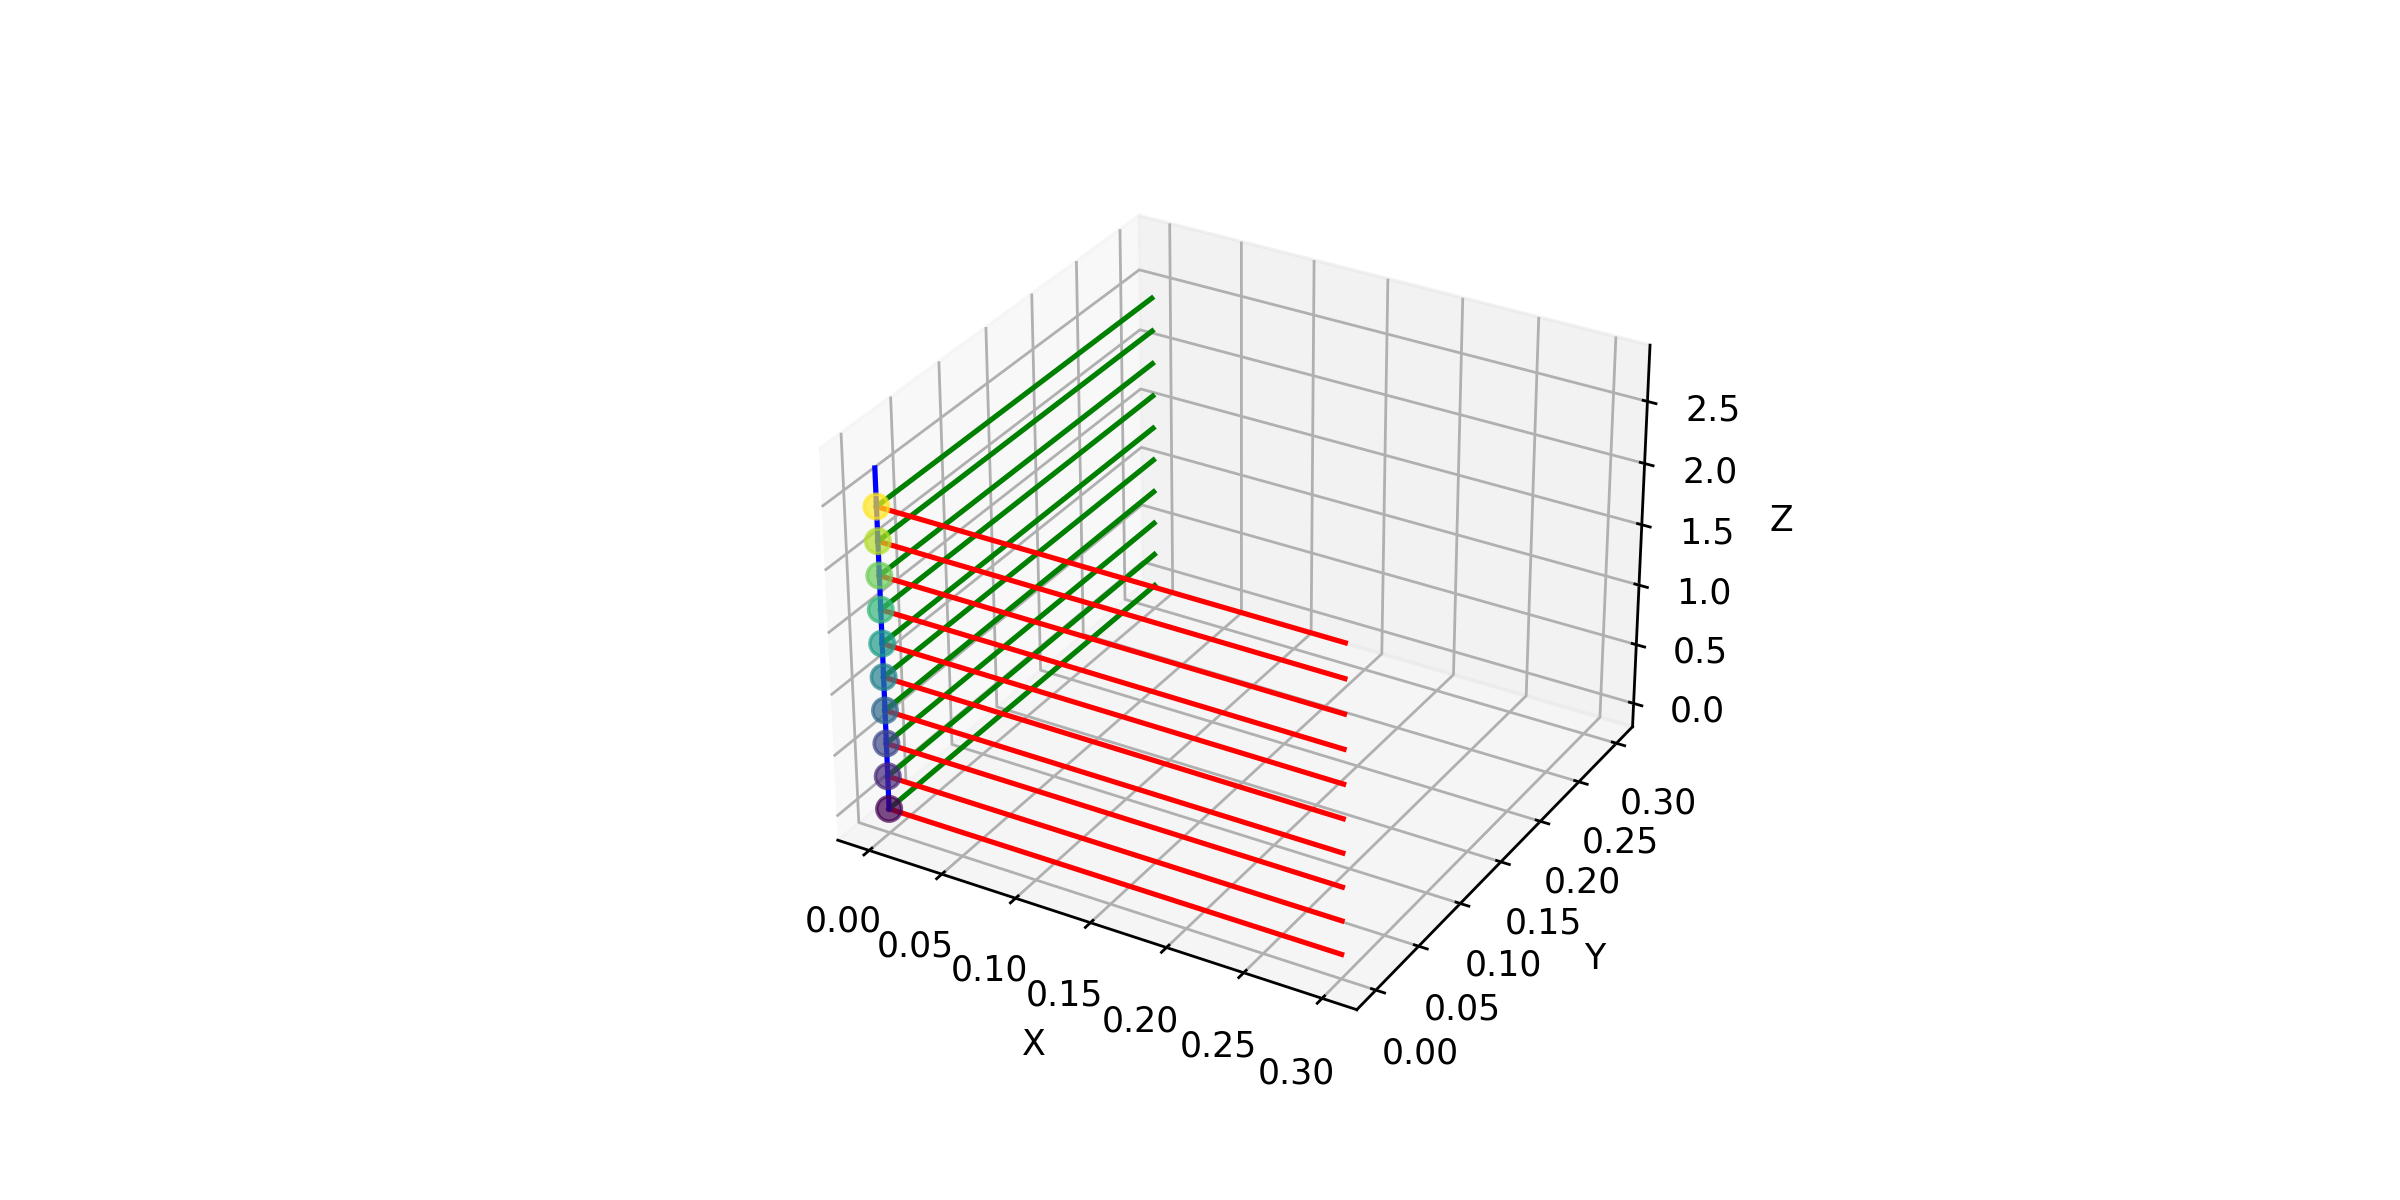

In [7]:
%matplotlib notebook
plot_poses(dataset2.camtoworlds[:10], 0.3)
# poses = dataset3.camtoworlds.copy()
# poses[:, :3, 3] *= (0.0785 / 133.3) # 
# poses, _ = camera_utils.recenter_poses(poses)
# plot_poses(poses, 0.3)
# plot_poses(dataset4.camtoworlds, 0.3)

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(16, 16))
n_images = dataset2.images.shape[0]
for i, img in enumerate(dataset2.images):
    plt.subplot(int(np.ceil(n_images / 4)), 4, i+1)
    plt.imshow(img)

In [ ]:
print(dataset2.camtoworlds[0])
print(dataset2.pixtocams[0])
print(dataset2.pixtocams.shape)
print(np.linalg.inv(dataset2.pixtocams))
for i in range(3):
    print(np.linalg.norm(dataset2.camtoworlds[0, i, :3]))
    print(np.linalg.norm(dataset2.camtoworlds[0, :3, i]))

In [ ]:
# First and last image.
fig = plt.figure(figsize=plt.figaspect(0.5))
plt.subplot(1, 2, 1)
plt.imshow(dataset2.images[0])
plt.subplot(1, 2, 2)
plt.imshow(dataset2.images[-1])

In [ ]:
print(dataset2.images[0].dtype)
print(dataset2.images[0].shape)
print(np.min(dataset2.images[0]))
print(np.max(dataset2.images[0]))